# A Classical Machine Learning Problem: Predicting Customer Churn

```{index} Customer churn
```

Customer churn, where customers stop using a company's services, is a major concern for businesses as it directly impacts revenue. Traditionally, companies tackled this issue by manually analyzing past data and relying on the intuition of marketing and sales teams. They used methods like customer surveys, simple statistical analysis, and basic segmentation based on purchase history and customer interactions. These approaches provided some insights but were often reactive and lacked precision.

With the advent of machine learning, predicting and managing customer churn has become more efficient and accurate. Machine learning models can analyze vast amounts of data to identify patterns and predict which customers are likely to leave. These models consider various factors such as customer behavior, transaction history, and engagement metrics, providing a comprehensive analysis that traditional methods cannot match.

Machine learning enables real-time data processing, allowing businesses to react swiftly to at-risk customers. It also allows for personalized retention strategies, as models can segment customers into detailed groups and suggest specific actions for each group. Moreover, machine learning models continuously improve by learning from new data, ensuring they stay relevant as customer behaviors and market conditions change.

In this experiment, we will explore a small dataset which includes customer information and churn status. We will build a machine learning model to predict customer churn and evaluate its performance. By the end of this experiment, you will have a better understanding of how machine learning addresses this kind of business problem and how to apply it to real-world scenarios.

We will use a [bank customer churn dataset](https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn) from Kaggle, which contains information about bank customers and whether they churned or not.

## The dataset

Let's start by loading the dataset and examining its features.

In [1]:
# Download dataset

!kaggle datasets download -d radheshyamkollipara/bank-customer-churn -p .data/ --unzip

# Load dataset
import pandas as pd

churn = pd.read_csv('.data/Customer-Churn-Records.csv')
print("Train:", churn.shape)

Dataset URL: https://www.kaggle.com/datasets/radheshyamkollipara/bank-customer-churn
License(s): other
100%|█████████████████████████████████████████| 307k/307k [00:00<00:00, 666kB/s]
100%|█████████████████████████████████████████| 307k/307k [00:00<00:00, 662kB/s]
Train: (10000, 18)


We have $\mathbf{10000}$ rows, and $\mathbf{14}$ columns, not particularly large, but enough to build a simple model. Let's look at the available columns.

In [2]:
churn

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0,0,1,DIAMOND,300
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0,0,5,PLATINUM,771
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1,1,3,SILVER,564
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1,1,2,GOLD,339


We have a mix of categorical and numerical features, some will clearly be of no use for our model (`CustomerId`, `Surname`, `RowNumber`), so let us perform a little bit of cleansing. We will drop any rows with missing values and remove the columns mentioned above.

In [3]:

# Remove missing values, if any
churn = churn.dropna()
churn.shape

(10000, 18)

In [4]:
# Remove whitespaces from column names
churn.columns = churn.columns.str.strip()

# Drop CustomerID, RowNumber and Surname columns
churn = churn.drop(columns=['CustomerId', 'RowNumber', 'Surname'])

That's better. Let's look at the data types of the columns.

In [5]:
churn.dtypes

CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned            int64
dtype: object

We have a mix of numerical and categorical columns, and some of the numerica columns are just truth - we will convert them to booleans. We will also convert the categorical columns to one-hot encoded columns.

In [8]:
import pandas as pd

# Convert binary features to booleans, 1 as True, 0 as False
churn['Exited'] = churn['Exited'].astype(bool)
churn['Complain'] = churn['Complain'].astype(bool)
churn['HasCrCard'] = churn['HasCrCard'].astype(bool)
churn['IsActiveMember'] = churn['IsActiveMember'].astype(bool)

# One-hot encode categorical features
churn_encoded = pd.get_dummies(churn, drop_first=True)

```{admonition} One-hot vs label encoding
:class: tip
One-hot encoding and label encoding are two common techniques for converting categorical data into a numerical format that machine learning algorithms can process. One-hot encoding is used when the categorical variables are nominal, meaning there is no inherent order among the categories. This technique creates a new binary column for each category, with a 1 indicating the presence of the category and a 0 indicating its absence. This approach ensures that the model does not assume any ordinal relationship between the categories, making it suitable for algorithms that are sensitive to numerical relationships, such as linear regression and K-nearest neighbors.

On the other hand, label encoding assigns a unique integer to each category, which is more suitable for ordinal categorical variables where the categories have a meaningful order. This method is straightforward and efficient in terms of memory and computational resources, especially when dealing with a large number of categories. However, it may introduce an artificial ordinal relationship if used on nominal variables, potentially misleading the model.

While one-hot encoding can lead to high-dimensional data, especially with many categories, it prevents the introduction of unintended ordinal relationships. Label encoding, being more compact, works well with tree-based algorithms like decision trees and random forests that can handle numerical encodings without assuming any specific order. The choice between the two methods depends on the nature of the categorical data and the requirements of the machine learning algorithm used. One-hot encoding is preferred for non-ordinal data and algorithms sensitive to numerical relationships, while label encoding is ideal for ordinal data and tree-based algorithms.
```

Let's look at what the data looks like now.

In [9]:
churn_encoded

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER
0,619,42,2,0.00,1,True,True,101348.88,True,True,2,464,False,False,False,False,False,False
1,608,41,1,83807.86,1,False,True,112542.58,False,True,3,456,False,True,False,False,False,False
2,502,42,8,159660.80,3,True,False,113931.57,True,True,3,377,False,False,False,False,False,False
3,699,39,1,0.00,2,False,False,93826.63,False,False,5,350,False,False,False,True,False,False
4,850,43,2,125510.82,1,True,True,79084.10,False,False,5,425,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,771,39,5,0.00,2,True,False,96270.64,False,False,1,300,False,False,True,False,False,False
9996,516,35,10,57369.61,1,True,True,101699.77,False,False,5,771,False,False,True,False,True,False
9997,709,36,7,0.00,1,False,True,42085.58,True,True,3,564,False,False,False,False,False,True
9998,772,42,3,75075.31,2,True,False,92888.52,True,True,2,339,True,False,True,True,False,False


That's much better, we have all the columns in the best possible shape for a model, and we are ready to continue. Note the hot-encoded columns, which have been added to the dataset, such as `Gender_Male` and `Geography_Germany`.

## Understanding the data better

It is always a good idea to grasp the data better before diving into building a model. One important first step is understanding the distribution types of the features, as this can help in selecting the appropriate machine learning algorithms and preprocessing techniques.

In [27]:
from scipy.stats import shapiro, kstest, anderson
import pandas as pd

# Define a function to interpret the p-value
def interpret_p_value(p, alpha=0.05):
    if p > alpha:
        return "likely Gaussian"
    else:
        return "unlikely Gaussian"

# Create lists to store the results
columns = []
shapiro_results = []
ks_results = []
anderson_results = []

# Loop through each column and perform normality tests if it's numeric
for column in churn_encoded.select_dtypes(include=['int64', 'float64']).columns:
    columns.append(column)
    
    # Shapiro-Wilk Test
    stat, p = shapiro(churn_encoded[column])
    shapiro_results.append((stat, p, interpret_p_value(p)))
    
    # Kolmogorov-Smirnov Test
    norm_data = (churn_encoded[column] - churn_encoded[column].mean()) / churn_encoded[column].std()
    stat, p = kstest(norm_data, 'norm')
    ks_results.append((stat, p, interpret_p_value(p)))
    
    # Anderson-Darling Test
    result = anderson(churn_encoded[column])
    anderson_result = []
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        interpretation = "likely Gaussian" if result.statistic < cv else "unlikely Gaussian"
        anderson_result.append((sl, cv, interpretation))
    anderson_results.append((result.statistic, anderson_result))

# Create a DataFrame for the results
results = pd.DataFrame({
    'Feature': columns,
    'Shapiro-Wilk Stat': [res[0] for res in shapiro_results],
    'Shapiro-Wilk p-value': [res[1] for res in shapiro_results],
    'Shapiro-Wilk Interpretation': [res[2] for res in shapiro_results],
    'KS Stat': [res[0] for res in ks_results],
    'KS p-value': [res[1] for res in ks_results],
    'KS Interpretation': [res[2] for res in ks_results],
    'Anderson-Darling Stat': [res[0] for res in anderson_results],
    'Anderson-Darling Interpretation': ["; ".join([f"{sl}%: {cv:.3f} --> {interpretation}" for sl, cv, interpretation in res[1]]) for res in anderson_results]
})

# Display the results
results


/var/folders/yn/46gxkz715ml5fyjmrqr5wjxr0000gn/T/ipykernel_6333/2147227100.py:22: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 10000.
  stat, p = shapiro(churn_encoded[column])


,Feature,Shapiro-Wilk Stat,Shapiro-Wilk p-value,Shapiro-Wilk Interpretation,KS Stat,KS p-value,KS Interpretation,Anderson-Darling Stat,Anderson-Darling Interpretation
0,CreditScore,0.993922,3.470965e-20,unlikely Gaussian,0.019519,9.679060e-04,unlikely Gaussian,5.458213,15.0%: 0.576 --> unlikely Gaussian; 10.0%: 0.6...
1,Age,0.944107,1.307937e-51,unlikely Gaussian,0.100959,3.463528e-89,unlikely Gaussian,142.193839,15.0%: 0.576 --> unlikely Gaussian; 10.0%: 0.6...
2,Tenure,0.948627,3.884747e-50,unlikely Gaussian,0.107269,1.173806e-100,unlikely Gaussian,151.153761,15.0%: 0.576 --> unlikely Gaussian; 10.0%: 0.6...
3,Balance,0.845564,4.288579e-71,unlikely Gaussian,0.251560,0.000000e+00,unlikely Gaussian,651.853273,15.0%: 0.576 --> unlikely Gaussian; 10.0%: 0.6...
4,NumOfProducts,0.706093,4.358341e-85,unlikely Gaussian,0.327394,0.000000e+00,unlikely Gaussian,1345.019095,15.0%: 0.576 --> unlikely Gaussian; 10.0%: 0.6...
5,EstimatedSalary,0.956642,3.056073e-47,unlikely Gaussian,0.055095,7.977800e-27,unlikely Gaussian,104.400508,15.0%: 0.576 --> unlikely Gaussian; 10.0%: 0.6...
6,Satisfaction Score,0.889676,2.724568e-64,unlikely Gaussian,0.159693,3.023804e-223,unlikely Gaussian,353.188669,15.0%: 0.576 --> unlikely Gaussian; 10.0%: 0.6...
7,Point Earned,0.955255,8.997046e-48,unlikely Gaussian,0.059827,1.479053e-31,unlikely Gaussian,109.251137,15.0%: 0.576 --> unlikely Gaussian; 10.0%: 0.6...


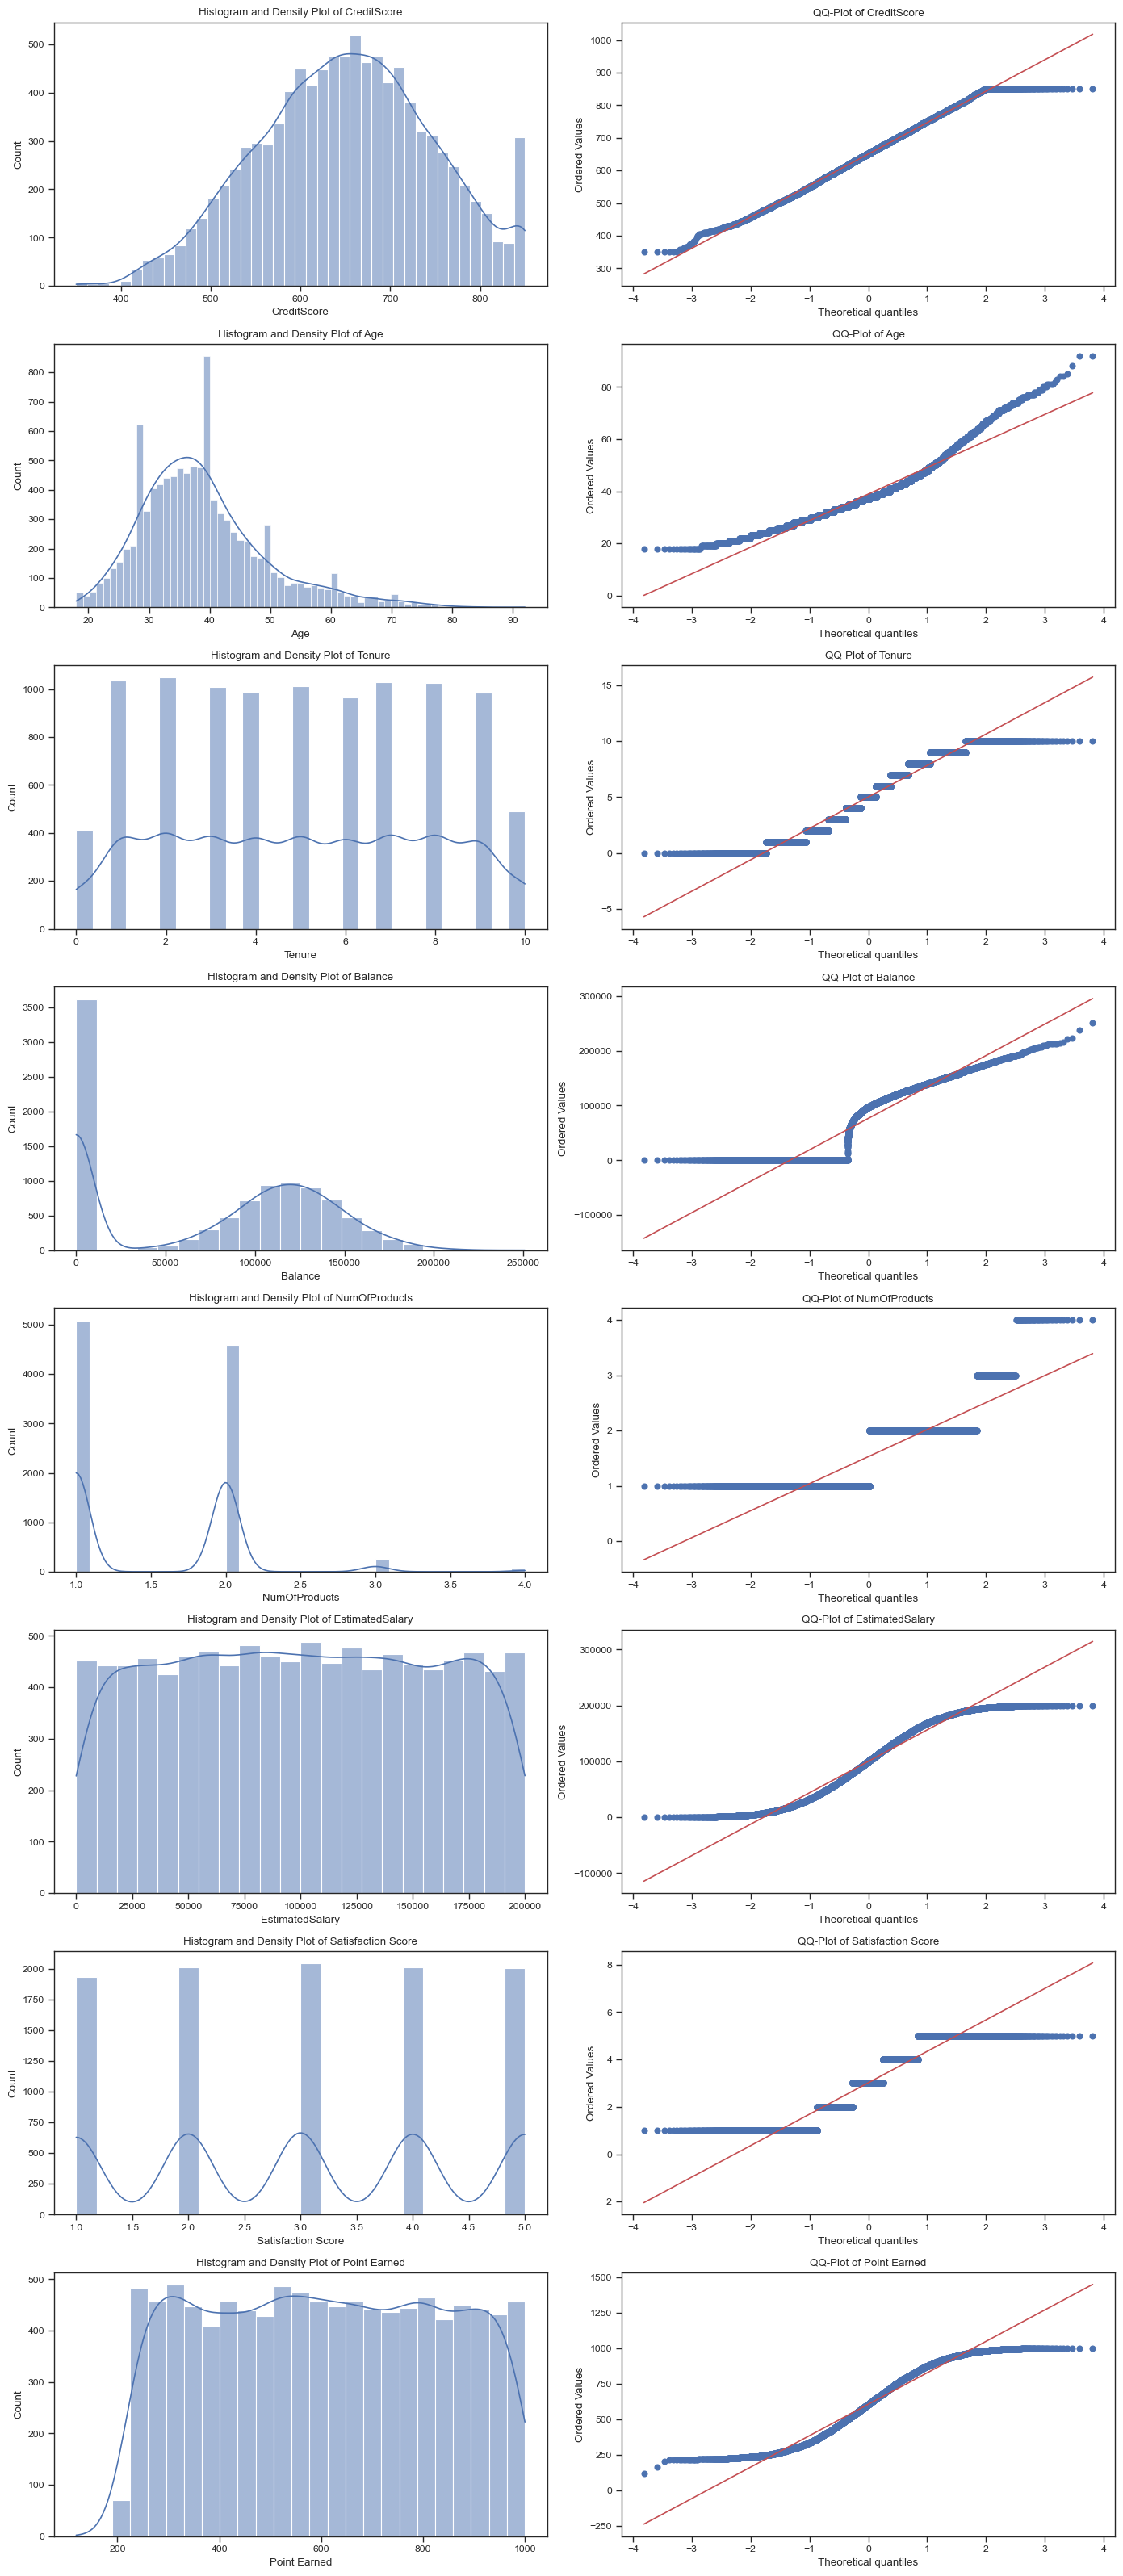

/Users/NLeitao/.pyenv/versions/3.9.18/envs/ml-env/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:6480: RuntimeWarning: overflow encountered in divide
  return np.sum((1 + np.log(shifted/scale)/shape**2)/shifted)
/Users/NLeitao/.pyenv/versions/3.9.18/envs/ml-env/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Fit results for CreditScore:
  Distribution  K-S Statistic       P-Value
0         norm       0.019514  9.716147e-04
1      lognorm       0.019516  9.700220e-04
2        expon       0.337120  0.000000e+00
3            t       0.019515  9.712211e-04
4       cauchy       0.095383  1.234923e-79


Fit results for Age:
  Distribution  K-S Statistic       P-Value
0         norm       0.100957  3.492314e-89
1      lognorm       0.040667  8.307332e-15
2        expon       0.279598  0.000000e+00
3            t       0.100956  3.505716e-89
4       cauchy       0.098068  3.627255e-84


Fit results for Tenure:
  Distribution  K-S Statistic        P-Value
0         norm       0.107280  1.119906e-100
1      lognorm       0.537069   0.000000e+00
2        expon       0.200747   0.000000e+00
3            t       0.107288  1.080255e-100
4       cauchy       0.129062  1.112077e-145


Fit results for Balance:
  Distribution  K-S Statistic  P-Value
0         norm       0.251572      0.0
1      lognorm     

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def plot_distributions_grid(data):
    # Select numeric columns
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    num_cols = len(numeric_cols)

    # Calculate grid size
    grid_rows = num_cols
    grid_cols = 2  # one for histogram, one for QQ-plot

    # Create subplots
    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(14, 4 * num_cols))
    
    for idx, column in enumerate(numeric_cols):
        # Plot histogram and density plot
        sns.histplot(data[column], kde=True, ax=axes[idx, 0])
        axes[idx, 0].set_title(f'Histogram and Density Plot of {column}')
        
        # Plot QQ-plot
        stats.probplot(data[column], dist="norm", plot=axes[idx, 1])
        axes[idx, 1].set_title(f'QQ-Plot of {column}')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

def fit_distributions(data):
    numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns
    distribution_results = {}

    for column in numeric_cols:
        distributions = ['norm', 'lognorm', 'expon', 't', 'cauchy']
        results = []
        
        for dist_name in distributions:
            dist = getattr(stats, dist_name)
            param = dist.fit(data[column])
            kstest_stat, kstest_p = stats.kstest(data[column], dist_name, args=param)
            results.append((dist_name, kstest_stat, kstest_p))
        
        distribution_results[column] = pd.DataFrame(results, columns=['Distribution', 'K-S Statistic', 'P-Value'])

    return distribution_results

# Example usage
plot_distributions_grid(churn_encoded)

distribution_results = fit_distributions(churn_encoded)
for column, result in distribution_results.items():
    print(f"Fit results for {column}:")
    print(result)
    print("\n")


Let's look at the distribution of the target variable, `Exited`, which indicates whether a customer churned or not, and the interdependencies between some of the features. A useful tool for this is a pair plot, which shows the relationships between pairs of features and how they correlate with the target variable.

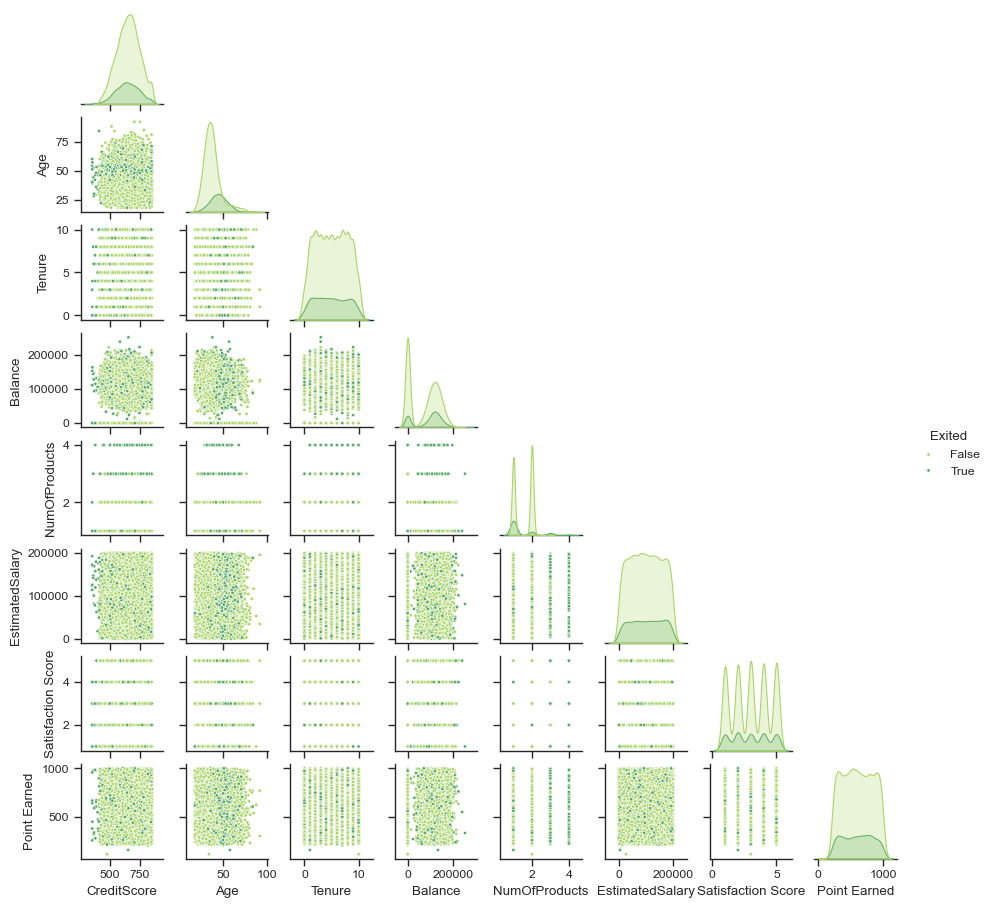

In [22]:

# Pairplot of the dataset for non-categorical features, with Exited as the target (stick to a sample for performance)
import seaborn as sns
import matplotlib.pyplot as plt

# Select non-categorical colums only
non_categorical_columns = churn_encoded.select_dtypes(exclude='bool').columns

# Plot the pairplot for the non-categorical columns only
sns.set_theme(context="paper", style="ticks")  # Set the style of the visualization
pairplot = sns.pairplot(
    churn,
    vars=non_categorical_columns,
    hue="Exited",
    palette="summer_r",
    corner=True,
    height=1.15,
    markers=[".", "."])
plt.show()

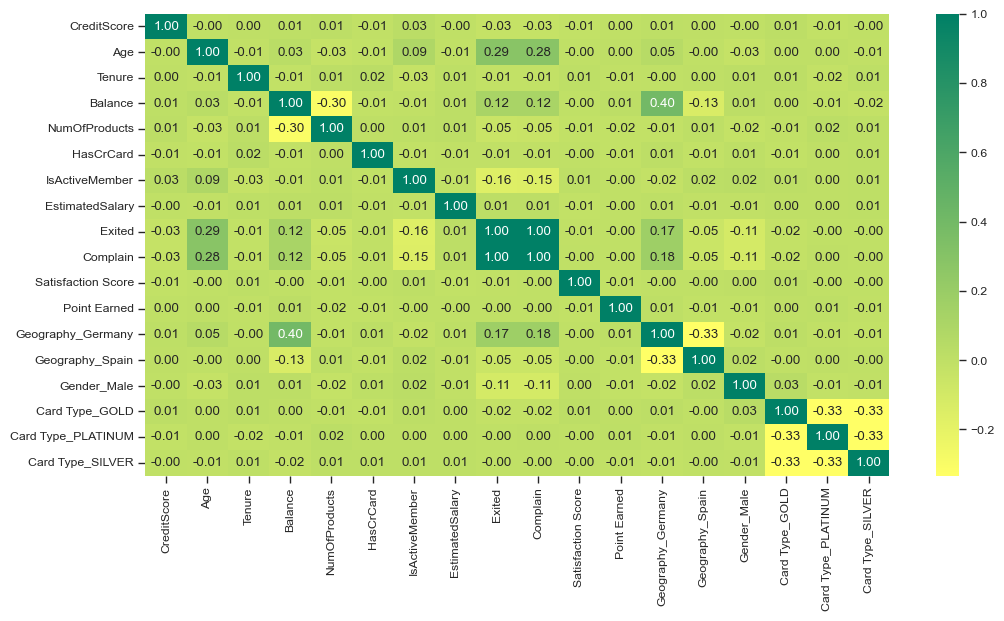

In [12]:
# Plot a correlation heatmap
plt.figure(figsize=(12, 6))
correlation = churn_encoded.corr()
heatmap = sns.heatmap(correlation, annot=True, cmap="summer_r", fmt=".2f")
plt.show()

In [13]:
# Drop the Complain feature
churn_encoded = churn_encoded.drop(columns=['Complain'])

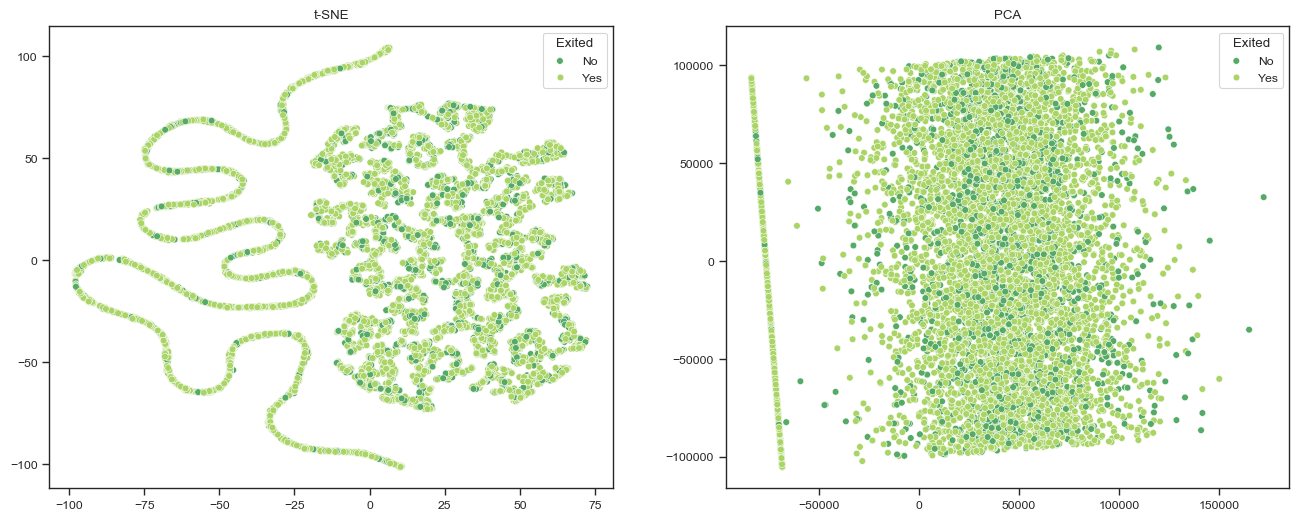

In [14]:

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Fit and transform t-SNE
tsne = TSNE(n_components=2, random_state=42)
churn_tsne = tsne.fit_transform(churn_encoded.drop(columns=['Exited']))

# Fit and transform PCA
pca = PCA(n_components=2, random_state=42)
churn_pca = pca.fit_transform(churn_encoded.drop(columns=['Exited']))

hue_order = churn_encoded['Exited'].unique()

# Plot t-SNE and PCA side by side
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot t-SNE
tsne_plot = sns.scatterplot(
    x=churn_tsne[:, 0],
    y=churn_tsne[:, 1],
    hue=churn_encoded['Exited'],
    palette="summer_r",
    ax=ax[0])
tsne_plot.set_title("t-SNE")
tsne_plot.legend(title='Exited', loc='upper right', labels=['No', 'Yes'])

# Plot PCA
pca_plot = sns.scatterplot(
    x=churn_pca[:, 0],
    y=churn_pca[:, 1],
    hue=churn_encoded['Exited'],
    palette="summer_r",
    ax=ax[1])
pca_plot.set_title("PCA")
pca_plot.legend(title='Exited', loc='upper right', labels=['No', 'Yes'])

plt.show()

In [15]:
# Count the number of churned and non-churned samples
print(churn_encoded['Exited'].value_counts())

Exited
False    7962
True     2038
Name: count, dtype: int64


In [16]:
from sklearn.model_selection import train_test_split

# Separate features and target variable
X = churn_encoded.drop(columns=['Exited'])
y = churn_encoded['Exited']

# Split the data into balanced train and test sets using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Print the shapes of the resulting datasets
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

# Verify the proportions of the 'Churn' column in the train and test sets
print("Train set 'Exited' value counts:")
print(y_train.value_counts(normalize=False))
print("Test set 'Exited' value counts:")
print(y_test.value_counts(normalize=False))

X_train: (7000, 16) y_train: (7000,)
X_test: (3000, 16) y_test: (3000,)
Train set 'Exited' value counts:
Exited
False    5573
True     1427
Name: count, dtype: int64
Test set 'Exited' value counts:
Exited
False    2389
True      611
Name: count, dtype: int64


In [17]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

# Define a function to create pipelines and perform Grid Search
def create_and_fit_model(model, param_grid, X_train, y_train, cv=3):
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', model)
    ])
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv)
    grid_search.fit(X_train, y_train)
    
    return grid_search

# Define the models and their respective hyperparameters
models_and_params = [
    (RandomForestClassifier(random_state=42), {
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [10, 15, 20, 25]
    }),
    (LogisticRegression(random_state=42), {
        'model__C': [0.1, 1, 10]
    }),
    (GradientBoostingClassifier(random_state=42), {
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [5, 7, 11, 13]
    }),
    (SVC(random_state=42, probability=True), {
        'model__C': [0.1, 1, 10],
        'model__gamma': ['scale', 'auto'],
        'model__kernel': ['linear', 'rbf', 'poly']
    }),
    (KNeighborsClassifier(), {
        'model__n_neighbors': [3, 5, 7, 9],
        'model__weights': ['uniform', 'distance']
    }),
    (GaussianNB(), {}),
    (XGBClassifier(random_state=42), {
        'model__n_estimators': [50, 100, 200, 300],
        'model__max_depth': [3, 5, 7, 9],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }),
    (AdaBoostClassifier(algorithm='SAMME', random_state=42), {
        'model__n_estimators': [50, 100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 1]
    })
]

# Perform Grid Search for each model
grid_results = []
for model, param_grid in models_and_params:
    grid_search = create_and_fit_model(model, param_grid, X_train, y_train)
    grid_results.append(grid_search)

# Extract the fitted models
rf_grid, lr_grid, gb_grid, svc_grid, knn_grid, nb_grid, xgb_grid, ada_grid = grid_results

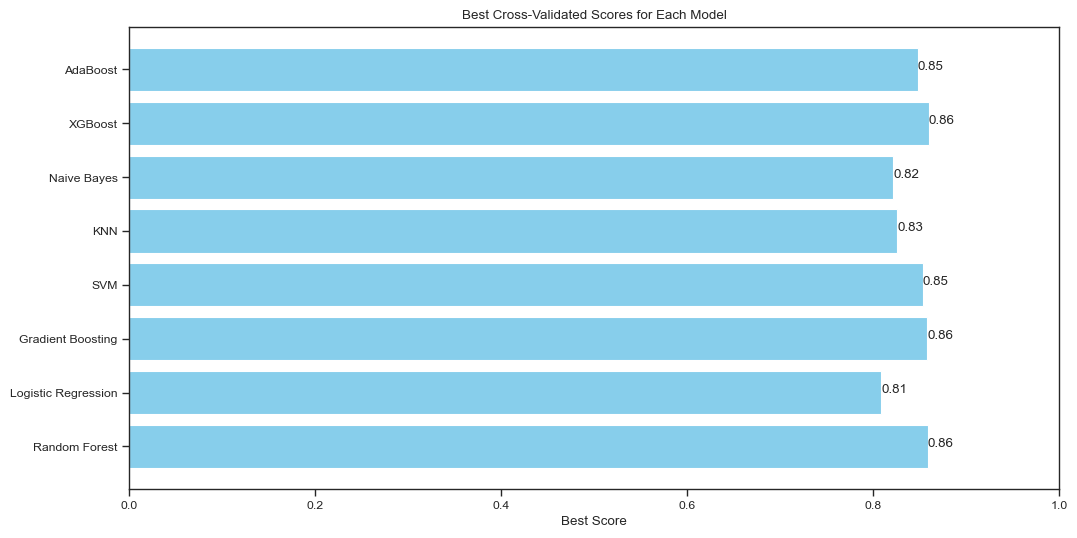

In [18]:
import matplotlib.pyplot as plt

# Model names
model_names = [
    "Random Forest",
    "Logistic Regression",
    "Gradient Boosting",
    "SVM",
    "KNN",
    "Naive Bayes",
    "XGBoost",
    "AdaBoost"
]

# Best scores
best_scores = [
    rf_grid.best_score_,
    lr_grid.best_score_,
    gb_grid.best_score_,
    svc_grid.best_score_,
    knn_grid.best_score_,
    nb_grid.best_score_,
    xgb_grid.best_score_,
    ada_grid.best_score_,
]

# Plotting best scores
plt.figure(figsize=(12, 6))
plt.barh(model_names, best_scores, color='skyblue')
plt.xlabel('Best Score')
plt.title('Best Cross-Validated Scores for Each Model')
plt.xlim(0, 1)
for index, value in enumerate(best_scores):
    plt.text(value, index, f'{value:.2f}')
plt.show()


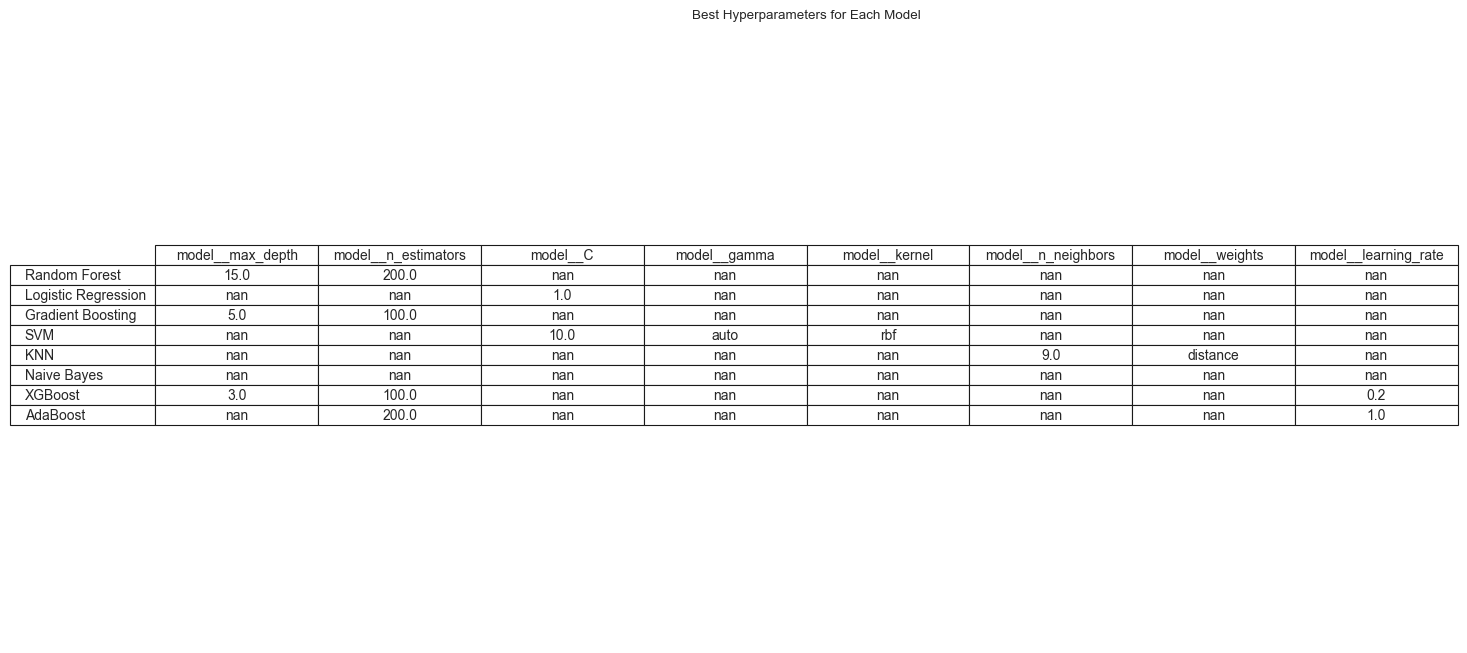

In [19]:
import pandas as pd

# Model names (ensure this list matches the one used in the bar plot)
model_names = [
    "Random Forest",
    "Logistic Regression",
    "Gradient Boosting",
    "SVM",
    "KNN",
    "Naive Bayes",
    "XGBoost",
    "AdaBoost"
]

# Collecting best parameters
best_params = [
    rf_grid.best_params_,
    lr_grid.best_params_,
    gb_grid.best_params_,
    svc_grid.best_params_,
    knn_grid.best_params_,
    nb_grid.best_params_,
    xgb_grid.best_params_,
    ada_grid.best_params_,
]

# Converting to a DataFrame for better visualization
params_df = pd.DataFrame(best_params, index=model_names)

# Plotting the best parameters for each model
fig, ax = plt.subplots(figsize=(14, 8))
ax.axis('off')
tbl = ax.table(cellText=params_df.values, colLabels=params_df.columns, rowLabels=params_df.index, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1.2, 1.2)
plt.title('Best Hyperparameters for Each Model')
plt.show()

In [20]:
from sklearn.metrics import classification_report

# Predict the target variable using the best models
rf_test_pred = rf_grid.predict(X_test)
lr_test_pred = lr_grid.predict(X_test)
gb_test_pred = gb_grid.predict(X_test)
svc_test_pred = svc_grid.predict(X_test)
knn_test_pred = knn_grid.predict(X_test)
nb_test_pred = nb_grid.predict(X_test)
xgb_test_pred = xgb_grid.predict(X_test)
ada_test_pred = ada_grid.predict(X_test)
mlp_test_pred = mlp_grid.predict(X_test)

# Print the classification report for each model
print("Random Forest test classification report:")
print(classification_report(y_test, rf_test_pred))

print("Logistic Regression test classification report:")
print(classification_report(y_test, lr_test_pred))

print("Gradient Boosting test classification report:")
print(classification_report(y_test, gb_test_pred))

print("Support Vector Machine test classification report:")
print(classification_report(y_test, svc_test_pred))

print("K-Nearest Neighbors test classification report:")
print(classification_report(y_test, knn_test_pred))

print("Gaussian Naive Bayes test classification report:")
print(classification_report(y_test, nb_test_pred))

print("XGBoost test classification report:")
print(classification_report(y_test, xgb_test_pred))

print("AdaBoost test classification report:")
print(classification_report(y_test, ada_test_pred))

NameError: name 'mlp_grid' is not defined

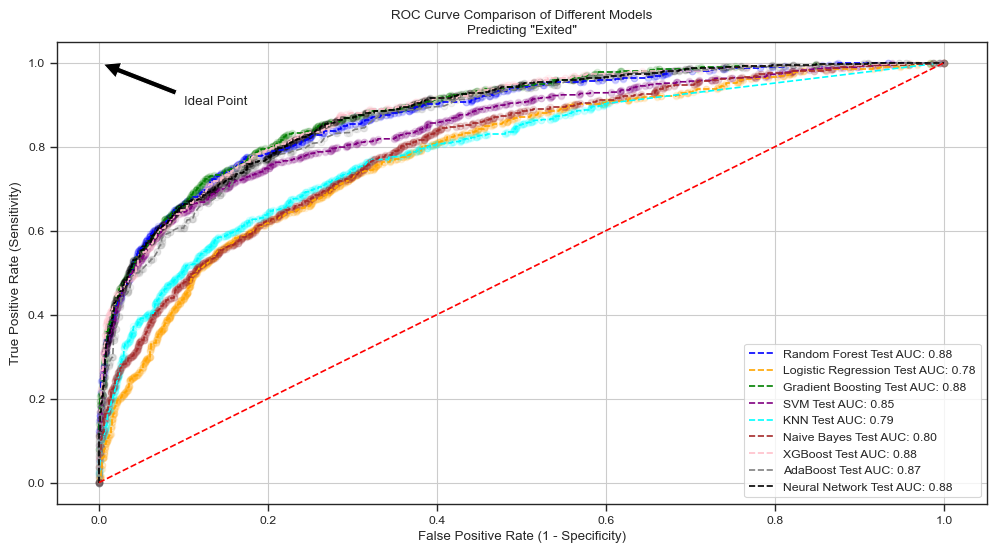

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Compute the probabilities for each model
rf_test_probs = rf_grid.predict_proba(X_test)[:, 1]
lr_test_probs = lr_grid.predict_proba(X_test)[:, 1]
gb_test_probs = gb_grid.predict_proba(X_test)[:, 1]
svc_test_probs = svc_grid.predict_proba(X_test)[:, 1]
knn_test_probs = knn_grid.predict_proba(X_test)[:, 1]
nb_test_probs = nb_grid.predict_proba(X_test)[:, 1]
xgb_test_probs = xgb_grid.predict_proba(X_test)[:, 1]
ada_test_probs = ada_grid.predict_proba(X_test)[:, 1]

# Compute the ROC curve for each model
rf_test_fpr, rf_test_tpr, _ = roc_curve(y_test, rf_test_probs)
lr_test_fpr, lr_test_tpr, _ = roc_curve(y_test, lr_test_probs)
gb_test_fpr, gb_test_tpr, _ = roc_curve(y_test, gb_test_probs)
svc_test_fpr, svc_test_tpr, _ = roc_curve(y_test, svc_test_probs)
knn_test_fpr, knn_test_tpr, _ = roc_curve(y_test, knn_test_probs)
nb_test_fpr, nb_test_tpr, _ = roc_curve(y_test, nb_test_probs)
xgb_test_fpr, xgb_test_tpr, _ = roc_curve(y_test, xgb_test_probs)
ada_test_fpr, ada_test_tpr, _ = roc_curve(y_test, ada_test_probs)

# Compute the ROC AUC score for each model
rf_test_auc = roc_auc_score(y_test, rf_test_probs)
lr_test_auc = roc_auc_score(y_test, lr_test_probs)
gb_test_auc = roc_auc_score(y_test, gb_test_probs)
svc_test_auc = roc_auc_score(y_test, svc_test_probs)
knn_test_auc = roc_auc_score(y_test, knn_test_probs)
nb_test_auc = roc_auc_score(y_test, nb_test_probs)
xgb_test_auc = roc_auc_score(y_test, xgb_test_probs)
ada_test_auc = roc_auc_score(y_test, ada_test_probs)

# Plot the ROC curve for each model
plt.figure(figsize=(12, 6))

plt.plot(rf_test_fpr, rf_test_tpr, label=f"Random Forest Test AUC: {rf_test_auc:.2f}", color='blue', linestyle='--')
plt.plot(lr_test_fpr, lr_test_tpr, label=f"Logistic Regression Test AUC: {lr_test_auc:.2f}", color='orange', linestyle='--')
plt.plot(gb_test_fpr, gb_test_tpr, label=f"Gradient Boosting Test AUC: {gb_test_auc:.2f}", color='green', linestyle='--')
plt.plot(svc_test_fpr, svc_test_tpr, label=f"SVM Test AUC: {svc_test_auc:.2f}", color='purple', linestyle='--')
plt.plot(knn_test_fpr, knn_test_tpr, label=f"KNN Test AUC: {knn_test_auc:.2f}", color='cyan', linestyle='--')
plt.plot(nb_test_fpr, nb_test_tpr, label=f"Naive Bayes Test AUC: {nb_test_auc:.2f}", color='brown', linestyle='--')
plt.plot(xgb_test_fpr, xgb_test_tpr, label=f"XGBoost Test AUC: {xgb_test_auc:.2f}", color='pink', linestyle='--')
plt.plot(ada_test_fpr, ada_test_tpr, label=f"AdaBoost Test AUC: {ada_test_auc:.2f}", color='grey', linestyle='--')

# Plot the random chance line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Add scatter points for threshold markers
plt.scatter(rf_test_fpr, rf_test_tpr, alpha=0.1, color='blue')
plt.scatter(lr_test_fpr, lr_test_tpr, alpha=0.1, color='orange')
plt.scatter(gb_test_fpr, gb_test_tpr, alpha=0.1, color='green')
plt.scatter(svc_test_fpr, svc_test_tpr, alpha=0.1, color='purple')
plt.scatter(knn_test_fpr, knn_test_tpr, alpha=0.1, color='cyan')
plt.scatter(nb_test_fpr, nb_test_tpr, alpha=0.1, color='brown')
plt.scatter(xgb_test_fpr, xgb_test_tpr, alpha=0.1, color='pink')
plt.scatter(ada_test_fpr, ada_test_tpr, alpha=0.1, color='grey')

# Annotate the ideal point
plt.annotate('Ideal Point', xy=(0, 1), xytext=(0.1, 0.9),
             arrowprops=dict(facecolor='black', shrink=0.05),
             )

# Axis labels
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

# Title and grid
plt.title('ROC Curve Comparison of Different Models\nPredicting "Exited"')
plt.grid(True)

# Legend in the right bottom corner
plt.legend(loc='lower right')
plt.show()